The Hull-White Short Rate Model is defined as:

<center><img src=".images/hw_eq.png"/></center>

where alpha and σ are constants (Extended Vasicek Model has alpha also as time dependent), and θ(t) is chosen in order to fit the input term structure of interest rates. Here we use QuantLib to show how to simulate the Hull-White model and investigate some of the properties. 

<center><img src=".images/hw_alpha.png"/></center>


Steps followed in the code below:
1. Input Data: 
We need a term structure of interest rates (yield curve) as an input. For this I am reusing the code in my previous commit. Please refer to yield_curves>USD>us_tsy_yield_curve.py file

2. Setting up the parameters: 
We need to setup multiple params for the model. First we set the maximum tenor till which we will project interest rates, then we select the time steps to discretise the grid. Finally, I have set the number of paths to be 4096 to give us good convergence results.

Note: I am not calibrating the alpha and σ params. We would need swaption volatilities data for this and short rate model calibration becomes a topic in itself. This code is just for demonstration purposes where we are projecting paths using the HW model given alpha and σ.

3. Generate Random Numbers and assign them to each Monte Carlo Paths:
We need to generate Monte Carlo Paths based on the conditions specified above. Finally I plot some charts to look at some of the outputs.


In [2]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt 
from yield_curves.USD.us_tsy_yield_curve import USTsyYieldCurve

In [3]:
class HullWhiteModel:
    def __init__(self, yield_curve: ql.YieldTermStructureHandle, analysis_date: ql.Date,
                 time_step: int = 360, projection_tenor: int = 30, num_paths: int = 4096, params: list = [0.01, 0.02]) -> None:
        # Initial Setup
        self.as_of_date = analysis_date
        self.yield_curve = yield_curve
        ql.Settings.instance().evaluationDate = self.as_of_date

        # Hull White Model variables
        self.timestep = time_step
        self.length = projection_tenor # in years
        self.num_paths = num_paths
        self.sigma = params[0]
        self.a = params[1]
        

        # Conventions
        self.day_count = ql.Thirty360(ql.Thirty360.BondBasis)

        # Default Calibration
        self._calibrate()

    def _calibrate(self):
        print("Calibrating Hull White Model")
        hw_process = ql.HullWhiteProcess(self.yield_curve, a=self.a, sigma=self.sigma)

        # Generate random numbers
        self.rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(self.timestep, ql.UniformRandomGenerator()))

        # Generate discretised random paths
        self.seq = ql.GaussianPathGenerator(hw_process, self.length, self.timestep, self.rng, False)
        print("Calibrated!")

    def set_params(self, a: float, sigma: float):
        self.a = a
        self.sigma = sigma

        # Recalibrate the model
        self._calibrate()
    
    # We define alpha as per above equations
    def get_alpha(self, time: float):
        # YF for 1-day (proxy for short rate)
        yf = self.day_count.yearFraction(self.as_of_date, self.as_of_date + ql.Period(str("1D")))
        forward = self.yield_curve.forwardRate(time, time + yf,
                                               ql.Compounded).rate()
        alpha = forward + 0.5* np.power(self.sigma/self.a*(1.0 - np.exp(-self.a*time)), 2)
        return alpha

    def generate_paths(self):
        arr = np.zeros((self.num_paths, self.timestep+1))
        for i in range(self.num_paths):
            sample_path = self.seq.next()
            path = sample_path.value()
            time = [path.time(j) for j in range(len(path))]
            value = [path[j] for j in range(len(path))]
            arr[i, :] = np.array(value)
        return np.array(time), arr

In [4]:
as_of_date = ql.Date(1, 5, 2024)
num_paths = 4096
time_step = 360
max_tenor = 30 # Years
yield_curve = USTsyYieldCurve(date=as_of_date).get_yield_curve_handle()
hw_model = HullWhiteModel(
    analysis_date=as_of_date,
    yield_curve=yield_curve,
    num_paths=num_paths,
    time_step=time_step,
    projection_tenor=max_tenor,
)

Fetched raw data from USDT website!
Created bond helpers for all tenors!
Successfully calibrated the yield curve!
Calibrating Hull White Model
Calibrated!


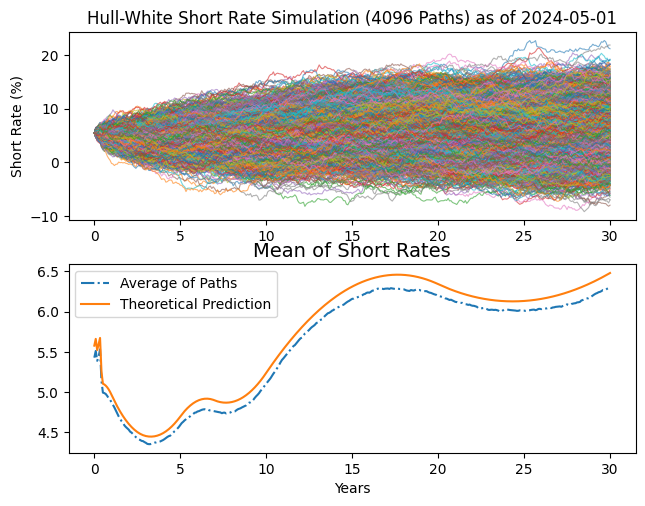

In [14]:
# Plotting the projected paths
time, paths = hw_model.generate_paths()
fig, axs = plt.subplots(2)
fig.tight_layout()

# Plot each path
for i in range(num_paths):
    axs[0].plot(time, np.multiply(paths[i, :], 100), lw=0.8, alpha=0.6)

axs[0].set_title(f"Hull-White Short Rate Simulation ({num_paths} Paths) as of {as_of_date.ISO()}")
axs[0].set_ylabel("Short Rate (%)")

# Plotting mean of every path
avg = [np.mean(paths[:, i]) * 100 for i in range(time_step + 1)]
alphas = [hw_model.get_alpha(t) * 100 for t in time]
axs[1].plot(time, avg, "-.", label="Average of Paths")
axs[1].plot(time, alphas, "-", label="Theoretical Prediction")
axs[1].set_title("Mean of Short Rates", size=14)
axs[1].set_xlabel("Years")
axs[1].legend()

plt.show()
